## GCN: Graph Convolutional Network

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271619300437-gr7_lrg.jpg">

ref. A graph convolutional neural network for classification of building patterns using spatial vector data ( https://www.sciencedirect.com/science/article/pii/S092427 )

## PyTorch Geometricセットアップ

**Runtime** GPU

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 8.9 MB/s 
     |████████████████████████████████| 3.5 MB 7.6 MB/s 


## 例題による入門

ref. https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

### グラフデータ

- **data.x**: shape **[num_nodes, num_node_features]** を持つ特徴行列
 - 各ノードが特徴を持つ。
- **data.edge_index**: shape **[2, num_edges]** と型 torch.long を持つ COO フォーマット（一般には疎行列座標表現を指す）によるグラフ連結度
- **data.edge_attr**: shape **[num_edges,num_edge_features]** によるエッジ特徴行列
 - エッジも特徴を持つことができる。
- **data.y**: 訓練するためのターゲット 。shapeは任意。
- **data.pos**: **[num_nodes, num_dimensions]** を持つノード位置行列

- 注意： PyTorchではTorchVision形式［画像、ラベル］を多用するが、PyGでは特にこうした制約を持たない。

**サンプルデータ**

In [2]:
# PyGグラフ ⇨ networkxグラフ
!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


３頂点グラフ。各頂点は特徴**feature**[-1], [0], [1]を持つ。頂点間は[0-1, 1-0, 1-2, 2-1]の辺で結ばれる。

In [4]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

<img src="https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg">

PyGグラフをnetworkxグラフに変換し、描画する。

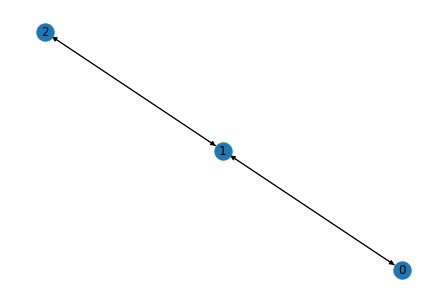

In [5]:
G=to_networkx(data)
nx.draw(G, with_labels=True)

PyGグラフ情報取得

In [6]:
data.keys

['edge_index', 'x']

In [7]:
data['x']

tensor([[-1.],
        [ 0.],
        [ 1.]])

In [8]:
'edge_attr' in data

False

In [9]:
data.num_nodes

3

In [10]:
data.num_edges

4

In [11]:
data.num_features

1

In [ ]:
data.has_isolated_nodes()

False

In [ ]:
data.has_self_loops()

False

In [ ]:
data.is_directed()

False

In [ ]:
# Transfer data object to GPU.
device = torch.device('cuda')
data = data.to(device)

### 共通ベンチマークセット

TORCH_GEOMETRIC.DATASETS<br>
ref. https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

例：Enzymesタンパク質

In [12]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [13]:
len(dataset) # 600グラフ

600

In [14]:
dataset.num_classes # 6種類

6

In [15]:
dataset.num_node_features # ３特徴

3

In [16]:
data = dataset[0]
print(data.num_nodes)
print(data.edge_index.shape)
print(data.x.shape)
print(data.y.shape)

37
torch.Size([2, 168])
torch.Size([37, 3])
torch.Size([1])


In [17]:
import random
random.sample(list(data.x), 5)

[tensor([1., 0., 0.]),
 tensor([0., 1., 0.]),
 tensor([0., 1., 0.]),
 tensor([1., 0., 0.]),
 tensor([1., 0., 0.])]

In [18]:
# train data 例
dataset[:540]

ENZYMES(540)

In [19]:
# test data　例
dataset[:60]

ENZYMES(60)

In [20]:
# データをシャッフル
dataset.shuffle()

ENZYMES(600)

例 Cora (半教師データ）

In [21]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [22]:
# グラフ数
len(dataset)

1

In [23]:
dataset[0].num_nodes

2708

In [ ]:
# ジャンル数
dataset.num_classes

7

In [ ]:
# 特徴サイズ
dataset.num_node_features

1433

In [ ]:
import pprint
pprint.pprint(tuple(dataset.data.items()))

(('x',
  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])),
 ('edge_index',
  tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])),
 ('y', tensor([3, 4, 4,  ..., 3, 3, 3])),
 ('train_mask', tensor([ True,  True,  True,  ..., False, False, False])),
 ('val_mask', tensor([False, False, False,  ..., False, False, False])),
 ('test_mask', tensor([False, False, False,  ...,  True,  True,  True])))


In [25]:
# train maskの数
data = dataset[0]
data.train_mask.sum().item()

140

## ミニバッチ

In [26]:
from torch_geometric.datasets import TUDataset
# edge_index, x, yを自動でバッチ化する
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for i, batch in enumerate(loader):
  print(batch)
  if i>=3: break

DataBatch(edge_index=[2, 3920], x=[1076, 21], y=[32], batch=[1076], ptr=[33])
DataBatch(edge_index=[2, 4036], x=[1014, 21], y=[32], batch=[1014], ptr=[33])
DataBatch(edge_index=[2, 4278], x=[1065, 21], y=[32], batch=[1065], ptr=[33])
DataBatch(edge_index=[2, 4098], x=[1097, 21], y=[32], batch=[1097], ptr=[33])


## Data Transform

省略。

## 学習モデル例：GCN

In [27]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

学習

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
# 5e-4: 5*10^(-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad() # 勾配の初期化
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

テスト評価

In [30]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7920
